### Reading data and data cleaning

In [117]:
import pandas as pd

# Read Excel File
df = pd.read_excel(
    'data/Served Meal Count.xlsx',
    usecols=['Date','Breakfast Order','Breakfast Served','Lunch Order', 'Lunch Served']
)

# Convert the Date column to the datetime format specific to the pandas library.
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
0,2023-08-21,380,289,350,275
1,2023-08-22,380,332,350,272
2,2023-08-23,380,346,350,288
3,2023-08-24,380,366,350,292
4,2023-08-25,380,367,312,284
...,...,...,...,...,...
219,2024-10-01,377,310,357,297
220,2024-10-02,388,336,366,317
221,2024-10-03,369,323,338,301
222,2024-10-04,373,313,344,300


In [118]:
# Generate a complete data range
date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
# Set the index to the Date column
df.set_index('Date', inplace=True)
# Reindex to a complete date range, filling missing date rows with NaN.
df = df.reindex(date_range)
# For missing values, fill with 0.
df.fillna(0, inplace=True)
df

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served
2023-08-21,380.0,289.0,350.0,275.0
2023-08-22,380.0,332.0,350.0,272.0
2023-08-23,380.0,346.0,350.0,288.0
2023-08-24,380.0,366.0,350.0,292.0
2023-08-25,380.0,367.0,312.0,284.0
...,...,...,...,...
2024-10-03,369.0,323.0,338.0,301.0
2024-10-04,373.0,313.0,344.0,300.0
2024-10-05,0.0,0.0,0.0,0.0
2024-10-06,0.0,0.0,0.0,0.0


### Visualize the Raw Data

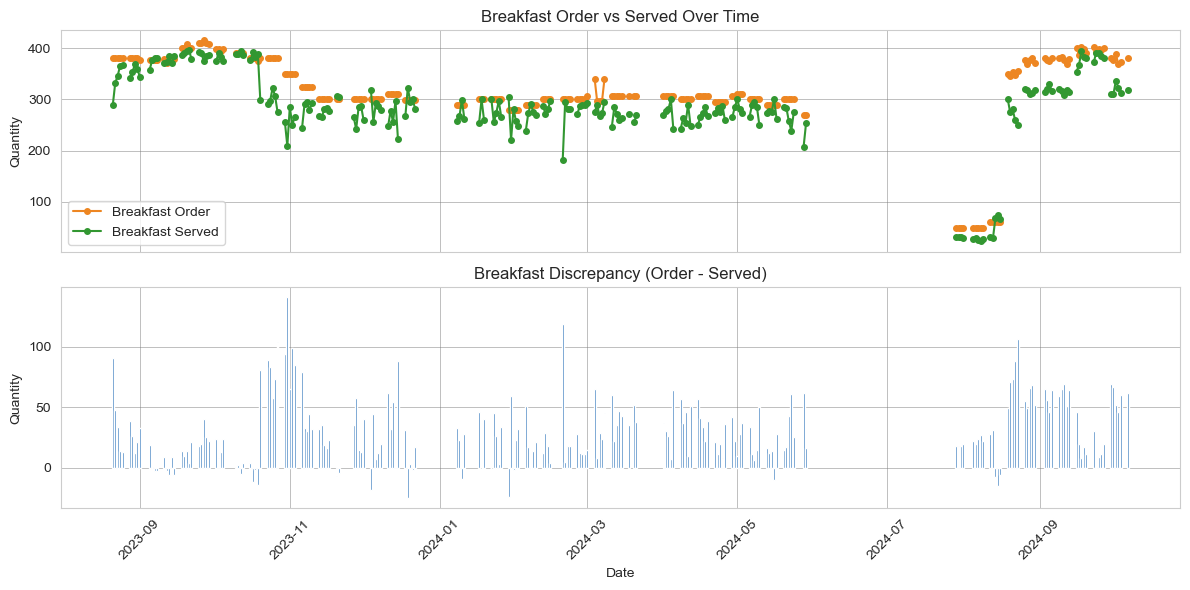

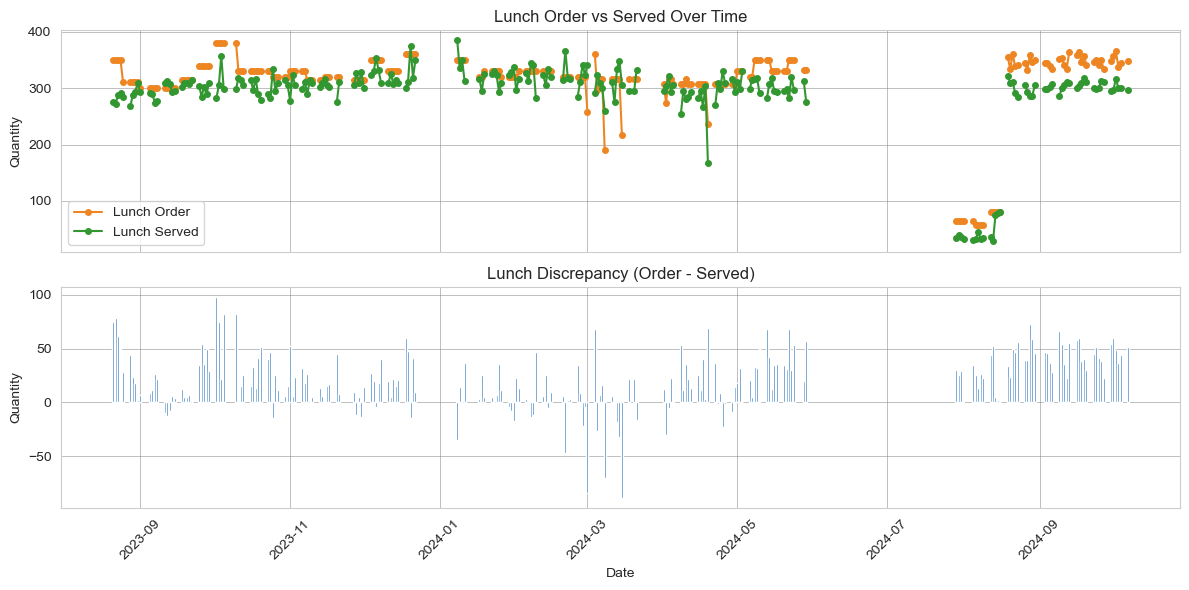

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Assume df is defined and contains 'Lunch Order' and 'Lunch Served' columns
# Create the data for plotting, replacing 0 with NaN

breakfast_served_plot = df['Breakfast Served'].replace(0, np.nan)
breakfast_order_plot = df['Breakfast Order'].replace(0, np.nan)
lunch_served_plot = df['Lunch Served'].replace(0, np.nan)
lunch_order_plot = df['Lunch Order'].replace(0, np.nan)

# Calculate the difference
breakfast_order_served_diff = breakfast_order_plot - breakfast_served_plot
lunch_order_served_diff = lunch_order_plot - lunch_served_plot

# Create a figure with subplots for each data column
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# First subplot: Breakfast Order vs Breakfast Served
ax1.plot(breakfast_order_plot, label='Breakfast Order', color=np.array([237, 134, 34]) / 255, alpha=1, marker='o', markersize=4)  # Orange
ax1.plot(breakfast_served_plot, label='Breakfast Served', color=np.array([50, 151, 49]) / 255, marker='o', markersize=4)  # Green
ax1.set_title('Breakfast Order vs Served Over Time')
ax1.set_ylabel('Quantity')
ax1.legend()
ax1.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
# Second subplot: Bar chart of breakfast difference
ax2.bar(breakfast_served_plot.index, breakfast_order_served_diff, color=np.array([51, 120, 188]) / 255)
ax2.set_title('Breakfast Discrepancy (Order - Served)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Quantity')
ax2.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
# Adjust the x-axis label rotation for better display.
plt.xticks(rotation=45)
plt.tight_layout()  # Automatically adjust the subplot layout to fit the entire figure.
plt.show()

# Create the second figure, containing subplots for lunch.
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# First subplot: Lunch Order vs Lunch Served
ax3.plot(lunch_order_plot, label='Lunch Order', color=np.array([237, 134, 34]) / 255, alpha=1, marker='o', markersize=4)  # Orange
ax3.plot(lunch_served_plot, label='Lunch Served', color=np.array([50, 151, 49]) / 255, marker='o', markersize=4)  # Green
ax3.set_title('Lunch Order vs Served Over Time')
ax3.set_ylabel('Quantity')
ax3.legend()
ax3.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
# Second subplot: Bar chart of lunch difference
ax4.bar(lunch_served_plot.index, lunch_order_served_diff, color=np.array([51, 120, 188]) / 255)
ax4.set_title('Lunch Discrepancy (Order - Served)')
ax4.set_xlabel('Date')
ax4.set_ylabel('Quantity')
ax4.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.7)
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Automatically adjust the subplot layout to fit the entire figure.
plt.show()

### Feature extraction
For Breakfast, the served amount on a particular day may be related to factors such as "Month", "Weekend", Day of the week", "Holidays (official holidays, summer/winter breaks)", "Day of the year", "Daily breakfast served in the past 7 days(7 in total)", and "Daily lunch served in the past 7 days(7 in total)". These factors are used to predict the served amount for that day.

#### Extract potentially useful features.

In [120]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.pyplot as plt

# Generate U.S. public holiday markers using the 'holidays' library
us_holidays = holidays.US()

# Customize the summer and winter break periods
winter_break = pd.date_range(start='2023-12-25', end='2024-01-05')
spring_break = pd.date_range(start='2024-03-22', end='2024-03-25')
summer_break = pd.date_range(start='2024-06-03', end='2024-08-20')

# Add the summer and winter breaks to the 'holidays' library as custom holiday markers.
for date in winter_break:
    us_holidays[date] = "Winter Break"
for date in spring_break:
    us_holidays[date] = "Spring Break"
for date in summer_break:
    us_holidays[date] = "Summer Break"

# Add the "holiday" information to the original 'df' data table.
df['Is_Holiday'] = df.index.map(lambda x: 1 if x in us_holidays else 0)

# Add the "weekday" information to the 'df' data table.
df['Day_of_Week'] = df.index.dayofweek
df['Is_Weekend'] = df['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

# Add "month" and "day of the year" information to the 'df' data table.
df['Month'] = df.index.month                   
df['Day_of_Year'] = df.index.dayofyear         

# Add lag features ("Breakfast served amount from the previous 7 days", "Lunch served amount from the previous 7 days") to the 'df' data table.
# The served amount on the current day has a certain relationship with the served amount from previous days.
for i in range(1, 8):  
    df[f'Breakfast_Lag_{i}'] = df['Breakfast Served'].shift(i)
    df[f'Lunch_Lag_{i}'] = df['Lunch Served'].shift(i)

# For potential missing values, fill them with 0.
df.fillna(0, inplace=True)

# To view the current structure of 'df' data table
df
# Is_Holiday: "0" indicates that the day is not a holiday (neither an official holiday nor a custom holiday such as winter/summer break). "1" indicates that the day is a holiday.
# Day_of_Week: 0 to 6 represent Monday to Sunday, respectively.
# Is_Weekend： "0" indicates that it is "not a weekend", and "1" indicates that it "is a weekend".
# Month
# Day_of_Year
# Breakfast_Lag_1 ~ Breakfast_Lag_7: The "served quantity of Breakfast from the past 7 days."
# Lunch_Lag_1 ~ Lunch_Lag_7: The "served quantity of Lunch from the past 7 days."

,Breakfast Order,Breakfast Served,Lunch Order,Lunch Served,Is_Holiday,Day_of_Week,Is_Weekend,Month,Day_of_Year,Breakfast_Lag_1,...,Breakfast_Lag_3,Lunch_Lag_3,Breakfast_Lag_4,Lunch_Lag_4,Breakfast_Lag_5,Lunch_Lag_5,Breakfast_Lag_6,Lunch_Lag_6,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,380.0,289.0,350.0,275.0,0,0,0,8,233,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-22,380.0,332.0,350.0,272.0,0,1,0,8,234,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-23,380.0,346.0,350.0,288.0,0,2,0,8,235,332.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-24,380.0,366.0,350.0,292.0,0,3,0,8,236,346.0,...,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-08-25,380.0,367.0,312.0,284.0,0,4,0,8,237,366.0,...,332.0,272.0,289.0,275.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,369.0,323.0,338.0,301.0,0,3,0,10,277,336.0,...,311.0,295.0,0.0,0.0,0.0,0.0,380.0,311.0,385.0,313.0
2024-10-04,373.0,313.0,344.0,300.0,0,4,0,10,278,323.0,...,310.0,297.0,311.0,295.0,0.0,0.0,0.0,0.0,380.0,311.0
2024-10-05,0.0,0.0,0.0,0.0,0,5,1,10,279,313.0,...,336.0,317.0,310.0,297.0,311.0,295.0,0.0,0.0,0.0,0.0
2024-10-06,0.0,0.0,0.0,0.0,0,6,1,10,280,0.0,...,323.0,301.0,336.0,317.0,310.0,297.0,311.0,295.0,0.0,0.0


#### Select the truly useful features.
The 19 features mentioned above are just preliminarily considered as potentially useful information for prediction, but their actual usefulness needs to be verified. I can use Pearson correlation to calculate the correlation between the target variables ('Breakfast Served' and 'Lunch Served') and the 19 features. The closer the absolute value of the correlation between a feature and the target variable is to 1, the stronger the relationship between the feature and the target variable. Such a feature is relatively effective and can be used for prediction.

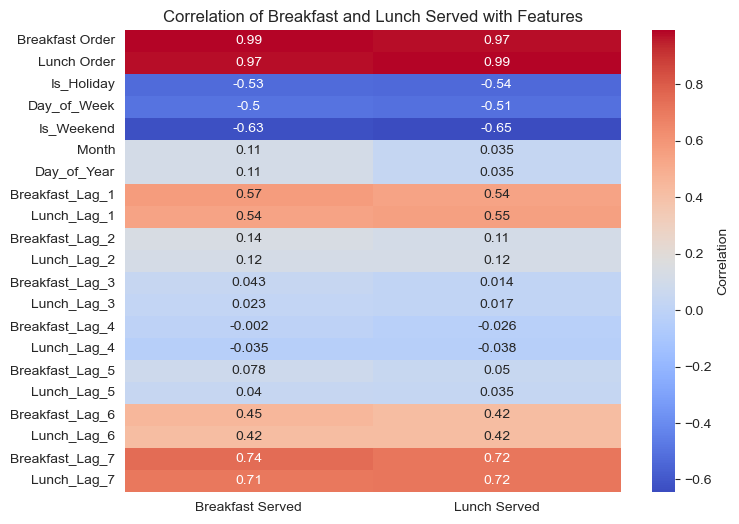

In [121]:
# Calculate the correlation between the 2 target variables ('Breakfast Served', 'Lunch Served') and the 19 potentially useful features.
correlation_matrix = df.corr()

# Extract the correlation between 'Breakfast Served' and 'Lunch Served' with the 19 features
target_corr = correlation_matrix[['Breakfast Served', 'Lunch Served']].drop(['Breakfast Served', 'Lunch Served'])

# Plot a heatmap of the correlation matrix
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(target_corr, annot=True, cmap='coolwarm', cbar_kws={'label': 'Correlation'})
plt.title("Correlation of Breakfast and Lunch Served with Features")
plt.show()

# From the heatmap, it can be observed that 'Breakfast Served' has a relatively high correlation (greater than or equal to 0.5) with 'Is_Holiday', 'Day_of_Week', 'Is_Weekend', 'Breakfast_Lag_1', 'Lunch_Lag_1', 'Breakfast_Lag_7', 'Lunch_Lag_7', 'Breakfast Order', 'Lunch Order'. 
# The situation is similar for 'Lunch Served' as well.
# Therefore, I plan to select the 9 features: 'Is_Holiday', 'Day_of_Week', 'Is_Weekend', 'Breakfast_Lag_1', 'Lunch_Lag_1', 'Breakfast_Lag_7', and 'Lunch_Lag_7', 'Breakfast Order', 'Lunch Order' as useful features for use.

In [122]:
# Filter out the features that have an absolute correlation of 0.5 or greater with the target variables
selected_features = target_corr[(target_corr.abs() >= 0.5).any(axis=1)]
selected_feature_names = selected_features.index.tolist()
selected_features
# The correlated features of 'Breakfast Served' and 'Lunch Served' happen to be the same, so the same feature data can be used for predicting both.

,Breakfast Served,Lunch Served
Breakfast Order,0.991640,0.974867
Lunch Order,0.973813,0.991729
Is_Holiday,-0.529078,-0.535473
Day_of_Week,-0.496294,-0.510313
Is_Weekend,-0.631880,-0.645659
Breakfast_Lag_1,0.569826,0.541043
Lunch_Lag_1,0.543133,0.552402
Breakfast_Lag_7,0.744906,0.715997
Lunch_Lag_7,0.707774,0.716495


In [123]:
# Based on the valid feature names selected above, extract these valid features from the df data table.
filtered_features = df[selected_feature_names]
filtered_features
# At this point, the feature extraction from the raw data has been completed. The extracted features will serve as the independent variables to predict the target variables ('Breakfast Served' and 'Lunch Served').

,Breakfast Order,Lunch Order,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,380.0,350.0,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,380.0,350.0,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,380.0,350.0,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,380.0,350.0,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,380.0,312.0,0,4,0,366.0,292.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-10-03,369.0,338.0,0,3,0,336.0,317.0,385.0,313.0
2024-10-04,373.0,344.0,0,4,0,323.0,301.0,380.0,311.0
2024-10-05,0.0,0.0,0,5,1,313.0,300.0,0.0,0.0
2024-10-06,0.0,0.0,0,6,1,0.0,0.0,0.0,0.0


### Split Dataset
1. The dataset is split into a training set and a validation set. The training set is used to train the model, while the validation set is used to evaluate the model's performance on unseen data.

2. The dataset ranges from 2023/08/21 to 2024/10/07. The period from 2023/08/21 to 2024/08/19 will be used as the training set, and the remaining data from 2024/08/19 to 2024/10/07 will serve as the validation set.

In [124]:
# Construct model input feature X and label y
X = filtered_features
y_breakfast = df['Breakfast Served']
y_lunch = df['Lunch Served']
# These two "order" variables are not used during model training, but they will be useful during the visualization process later. They are calculated in advance for future use.
order_breakfast = df['Breakfast Order']
order_lunch = df['Lunch Order']

In [125]:
# Obtain the time indices for the training data and testing data based on the cutoff date.
cutoff_date = '2024-08-19'
train_mask = X.index < cutoff_date
test_mask = X.index >= cutoff_date

# Extract training set
# Based on the previous correlation analysis, it is known that the effective feature variables for 'Breakfast Served' and 'Lunch Served' are exactly the same. Therefore, X_train_breakfast = X_train_lunch.
X_train_breakfast = X_train_lunch = X[train_mask]
y_train_breakfast = y_breakfast[train_mask]
y_train_lunch = y_lunch[train_mask]
# Extract testing set

# Extract the relevant data based on the test data's time index
X_test_breakfast = X_test_lunch = X[test_mask]
y_test_breakfast = y_breakfast[test_mask]
y_test_lunch = y_lunch[test_mask]

# Shuffle the training data
# This helps to prevent the model from relying on the order of the data and allows it to learn more general patterns.
X_train_breakfast_shuffled, y_train_breakfast_shuffled = shuffle(X_train_breakfast, y_train_breakfast, random_state=42)
X_train_lunch_shuffled, y_train_lunch_shuffled = shuffle(X_train_lunch, y_train_lunch, random_state=42)
# the testing set does not need to be shuffled because it is not used during model training.

# order of training set
order_train_breakfast = order_breakfast[train_mask]
order_train_lunch = order_lunch[train_mask]
# order of testing set
order_test_breakfast = order_breakfast[test_mask]
order_test_lunch = order_lunch[test_mask]

In [126]:
# Compare the time order of the training data before and after shuffling
X_train_breakfast.head()

,Breakfast Order,Lunch Order,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2023-08-21,380.0,350.0,0,0,0,0.0,0.0,0.0,0.0
2023-08-22,380.0,350.0,0,1,0,289.0,275.0,0.0,0.0
2023-08-23,380.0,350.0,0,2,0,332.0,272.0,0.0,0.0
2023-08-24,380.0,350.0,0,3,0,346.0,288.0,0.0,0.0
2023-08-25,380.0,312.0,0,4,0,366.0,292.0,0.0,0.0


In [127]:
X_train_breakfast_shuffled.head()

,Breakfast Order,Lunch Order,Is_Holiday,Day_of_Week,Is_Weekend,Breakfast_Lag_1,Lunch_Lag_1,Breakfast_Lag_7,Lunch_Lag_7
2024-03-01,307.0,257.0,0,4,0,289.0,324.0,282.0,317.0
2023-09-23,0.0,0.0,0,5,1,379.0,315.0,0.0,0.0
2023-09-05,377.0,300.0,0,1,0,0.0,0.0,354.0,288.0
2024-08-02,0.0,0.0,1,4,0,30.0,32.0,0.0,0.0
2023-10-17,380.0,330.0,0,1,0,376.0,315.0,389.0,298.0


### Model Training and Validation

#### Training 

In [128]:
# Use Random Forest regression model in this case.
# A separate model is constructed for each of the target variables, 'Breakfast Served' and 'Lunch Served'.
breakfast_model = RandomForestRegressor(n_estimators=256, random_state=42)
lunch_model = RandomForestRegressor(n_estimators=256, random_state=42)

In [129]:
# Train the model.
breakfast_model.fit(X_train_breakfast_shuffled, y_train_breakfast_shuffled)
lunch_model.fit(X_train_lunch_shuffled, y_train_lunch_shuffled)

RandomForestRegressor(n_estimators=256, random_state=42)

#### Inference

In [130]:
# On training data
# breakfast
pred_train_breakfast = breakfast_model.predict(X_train_breakfast)
# lunch
pred_train_lunch = lunch_model.predict(X_train_lunch)

# On testing data
pred_test_breakfast = breakfast_model.predict(X_test_breakfast)
pred_test_lunch = lunch_model.predict(X_test_lunch)

#### Performance(Visualize the results)

In [131]:
def plot_data(actual, predicted, orders=None, gap=True, key='Data Visualization', trans=True):
    if not isinstance(predicted, pd.Series):
        predicted = pd.Series(predicted, index=actual.index)
        
    if trans:
        actual = actual.replace(0, np.nan)
        predicted = predicted.replace(0, np.nan)
        if orders is not None:
            orders = orders.replace(0, np.nan)
    
    # Create subplots with a shared x-axis in Matplotlib
    fig, ax1 = plt.subplots(figsize=(14, 6), nrows=2, ncols=1, sharex=True)
    
    # Main Plot
    ax1[0].plot(actual.index, actual, label='Actual', color='blue', alpha=1.0, linestyle='-', linewidth=2)
    ax1[0].plot(actual.index, predicted, label='Predicted', color='orange', alpha=1.0, linestyle='-', linewidth=1.5)
    
    if orders is not None:
        ax1[0].plot(orders.index, orders, label='Orders', color='grey', alpha=1.0, linestyle=':', linewidth=1.5)
    
    ax1[0].set_title(f'Actual Served vs Predicted Served ({key})')
    ax1[0].set_ylabel('Quantity')
    ax1[0].legend()
    ax1[0].tick_params(axis='x', rotation=45)

    # Difference Bar Chart
    if gap:
        if orders is not None:
            diff_orders = orders - actual
            diff_predicted = predicted - actual
            
            ax1[1].bar(actual.index, diff_orders, label='Orders - Actual Served', color='grey', alpha=1.0)
            ax1[1].bar(actual.index, diff_predicted, label='Predicted Served - Actual Served', color='orange', alpha=1.0)
        else:
            diff_predicted = predicted - actual  
            ax1[1].bar(actual.index, diff_predicted, label='Predicted - Actual', color='orange', alpha=1.0)

        ax1[1].set_title(f'Discrepancy between Actual Served and Orders/Predicted Served ({key})' if orders is not None else f'Discrepancy between Actual Served and Predicted Served ({key})')
        ax1[1].set_ylabel('Quantity')
        ax1[1].legend()
    
    ax1[1].set_xlabel('Date')
    plt.tight_layout()
    plt.show()

##### Performance on train data

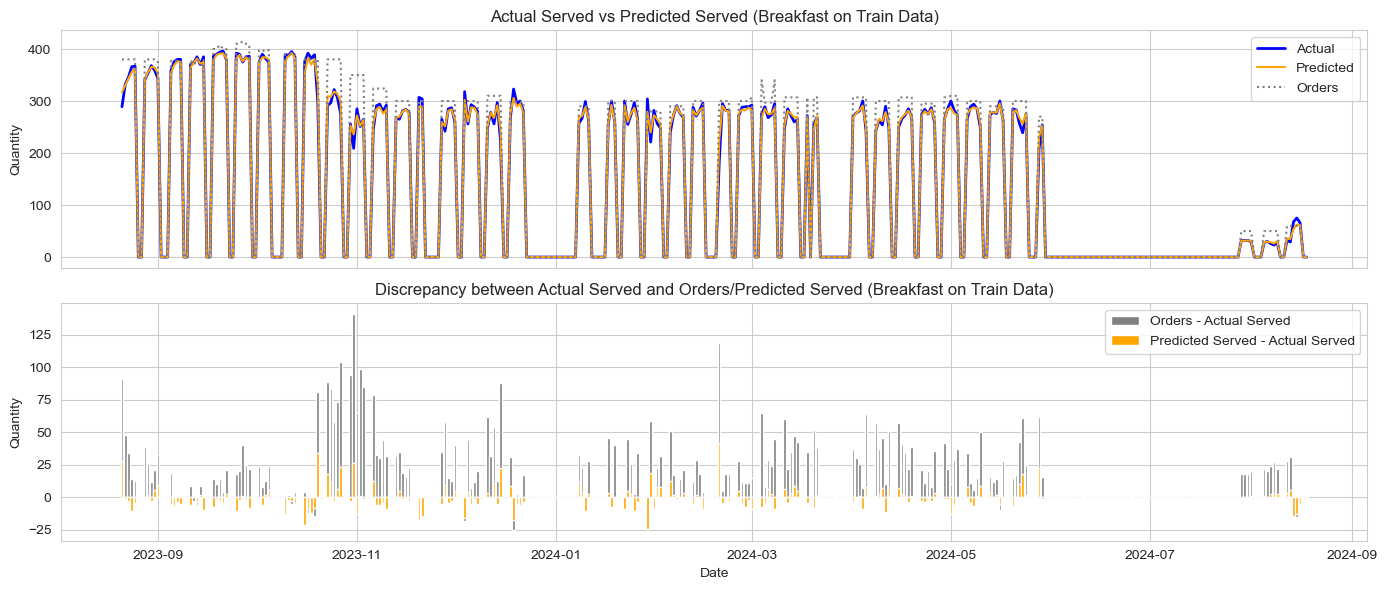

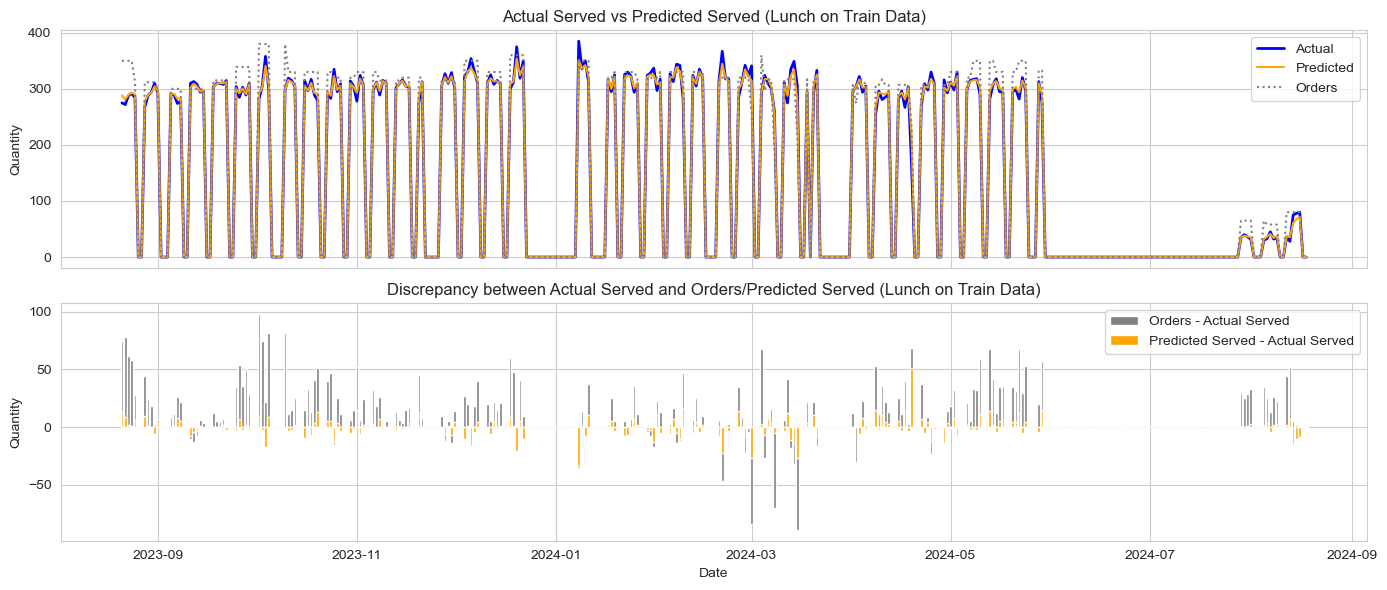

In [132]:
# breakfast
plot_data(y_train_breakfast, pred_train_breakfast, order_train_breakfast, 
          key='Breakfast on Train Data',
          trans=False)
# lunch
plot_data(y_train_lunch, pred_train_lunch, order_train_lunch, 
          key='Lunch on Train Data',
          trans=False)
# It can be observed that the orange line (predicted served) and the blue line (actual served) nearly overlap, indicating that the model can make accurate predictions on the training set.
# Compared to the gray line (order), this significantly reduces the daily gap between order and served.

##### Performance on test data

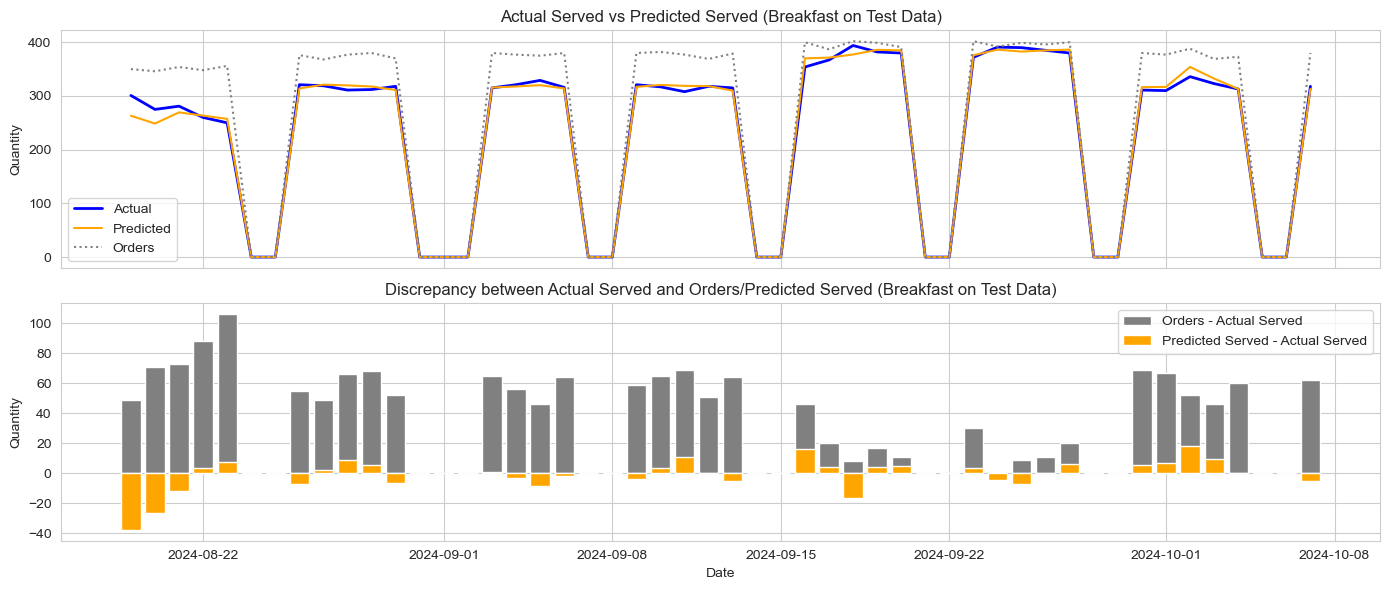

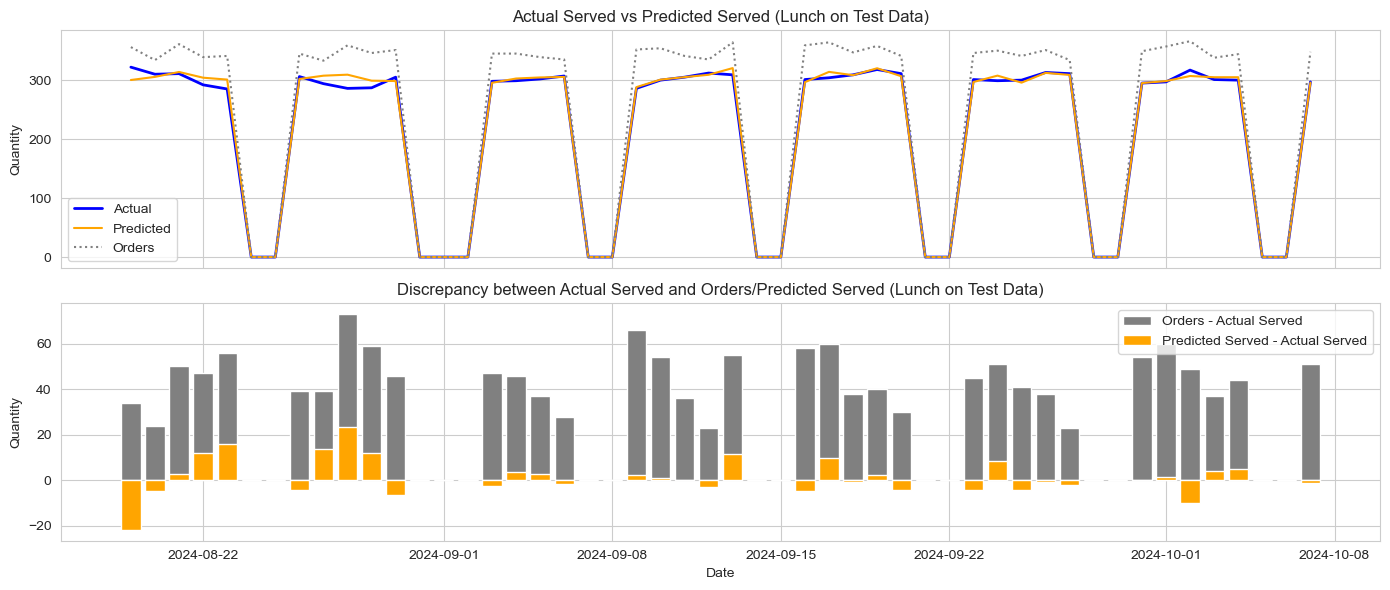

In [133]:
# breakfast
plot_data(y_test_breakfast, pred_test_breakfast, order_test_breakfast, 
          key='Breakfast on Test Data',
          trans=False)
# lunch
plot_data(y_test_lunch, pred_test_lunch, order_test_lunch, 
          key='Lunch on Test Data',
          trans=False)
# performance on the testing set further proves that the model can effectively predict the amount of breakfast served and lunch served

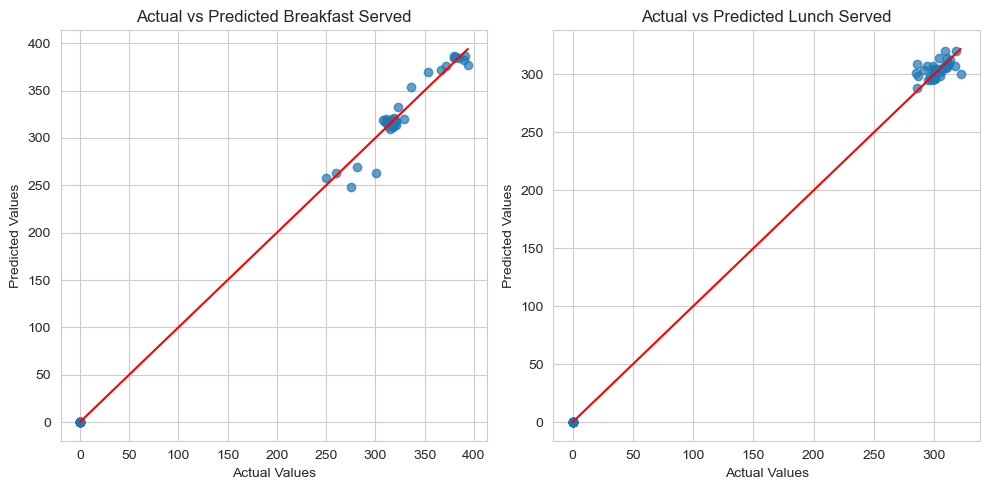

In [134]:
# Scatter Plot of Predictions vs Actuals
plt.figure(figsize=(10, 5))

# Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(y_test_breakfast, pred_test_breakfast, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Breakfast Served')
plt.plot([y_test_breakfast.min(), y_test_breakfast.max()],
         [y_test_breakfast.min(), y_test_breakfast.max()], color='red')  # Ideal Line

plt.subplot(1, 2, 2)
plt.scatter(y_test_lunch, pred_test_lunch, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Lunch Served')
plt.plot([y_test_lunch.min(), y_test_lunch.max()],
         [y_test_lunch.min(), y_test_lunch.max()], color='red')  # # Ideal Line

plt.tight_layout()
plt.show()

In [135]:
# To quantitatively evaluate the model's performance on the validation set, several metrics can be used. 
breakfast_mse = mean_squared_error(y_test_breakfast, pred_test_breakfast)
lunch_mse = mean_squared_error(y_test_lunch, pred_test_lunch)
breakfast_mae = mean_absolute_error(y_test_breakfast, pred_test_breakfast)
lunch_mae = mean_absolute_error(y_test_lunch, pred_test_lunch)
breakfast_r2 = r2_score(y_test_breakfast, pred_test_breakfast)
lunch_r2 = r2_score(y_test_lunch, pred_test_lunch)

print(f'Breakfast MSE: {breakfast_mse}')
print(f'Lunch MSE: {lunch_mse}')
print(f'Breakfast MAE: {breakfast_mae}')
print(f'Lunch MAE: {lunch_mae}')
print(f'Breakfast R² Score: {breakfast_r2}')
print(f'Lunch R² Score: {lunch_r2}')

Breakfast MSE: 80.8081118774414
Lunch MSE: 48.17093505859375
Breakfast MAE: 5.369609375
Lunch MAE: 4.1509375
Breakfast R² Score: 0.9965864403009822
Lunch R² Score: 0.9975019376819658
